In [1]:
    __test__ = dict(
        gold="""
        >>> g = a**str*[str.upper]|a**int*range|a**float*type
        >>> f = a/g*list
        >>> f(['keep it 💯', 10, 10.])
        [['KEEP IT 💯'], range(0, 10), <class 'float'>]
        >>> assert copy(g).type()({}) is Ø""",
        simple=""">>> assert a[range](10) == range(10)
        >>> assert a[range][type](10) is range 
        >>> assert a[range][type][type](10) is type
                
        Begin a composition with a decorator.
        >>> @a.append
        ... def thang(x):
        ...     return range(x)
        >>> assert thang[len](10) is 10""",
        juxt="""
        >>> assert juxt(range)(10) == range(10)
        >>> assert juxt([range])(10) == [range(10)]
        >>> assert juxt([range, type])(10) == [range(10), int]
        >>> assert juxt([range, type, str, 20])(10) == [range(10), int, '10', 20]
        
        Create a juxtaposable object `model`.
        >>> @juxt.append
        ... def model(x): return range(x)

        Append more functions to the `model`
        >>> @model.append
        ... def _(x): return type(x)
        
        >>> assert isinstance(juxt({})(), dict) and isinstance(juxt([])(), list) and isinstance(juxt(tuple())(), tuple)""")

# Complex Composite Functions

Complex composite functions have real and imaginary parts that may except specific errors.  

## Composition

Composite functions use Python syntax to append callable objects to compositions and juxtapositions.  

### Operator 

In [2]:
    from dataclasses import dataclass, field
    from functools import partialmethod, wraps
    import sys, operator, inspect
    from collections import Sized, Mapping, Iterable
    from toolz import excepts, complement, concat, reduce, groupby
    from copy import copy

    dunder = '__{}__'.format
    
    __all__ = 'a', 'an', 'the', 'simple', 'flip', 'parallel', 'star', 'do', 'preview', 'x',\
    'op', 'juxt', 'cache', 'store', 'Ø', 'functional', 'operation', \
    'proposition', 'exposition', 'imposition', 'λ', 'identity', 'partial'

In [3]:
    def isiterable(object): return isinstance(object, Iterable)

In [4]:
    binop = 'add', 'sub', 'mul', 'truediv', 'floordiv', 'mod', 'lshift', 'rshift', 'matmul'
    boolop =  'gt', 'ge', 'le', 'lt', 'eq', 'ne'
    nop = 'abs', 'pos', 'neg', 'pow'

Composing function strictly through the Python datamodel.

In [5]:
    def call(object, *tuple, Exception=None, **dict):  
        if Exception is None:
            return object(*tuple, **dict) if callable(object) else object
        try:
            return object(*tuple, **dict) if callable(object) else object
        except Exception as e:
            return Ø(object).with_traceback(e.__traceback__)
        
    def identity(*tuple, **dict): 
        """A identity function that returns the first arguments if it exists.
        
        >>> assert not identity(**dict(foo=42))
        >>> assert identity(10, 20, dict(foo=42)) is 10
        """
        return tuple[0] if tuple else None
    

In [38]:
    class partial(__import__('functools').partial):
        """Partial with logical
        >>> assert partial(range) == partial(range)
        >>> 
        """
        def __eq__(partial, object):
            if type(partial) is type(object):
                return (partial.func == object.func) and (partial.args == object.args)
            return False

In [7]:
    class this(partial):
        """Supply partial arguments to objects.
        
        >>> assert this(str.replace, 'a', 'b')('abc') == 'bbc'
        """
        def __call__(x, object): return x.func(object, *x.args, **x.keywords)

In [8]:
    class flip(partial):
        """Flip the argument of a callable.
        
        >>> assert flip(range)(20, 10) == range(10, 20)
        """
        def __call__(flip, *tuple, **dict): return super().__call__(*reversed(tuple), *reversed(flip.args), **dict)

In [9]:
    class do(partial):
        def __call__(do, *tuple, **dict): 
            super().__call__(do.args, **dict)
            return identity(*do.args)

In [10]:
    class star(partial):
        """Flip the argument of a callable.
        
        >>> assert star(range)((10, 20)) == range(10, 20)
        """
        def __call__(star, object): 
            if isinstance(object, Mapping):
                object = {**star.keywords, **object}
                return super().__call__(*star.args, **object)
            if isiterable(object):
                return super().__call__(*star.args, *object, **star.keywords)
            return super().__call__(object)

In [11]:
    class state:        
        def __getstate__(state):
            return tuple(getattr(state, slot, None) for slot in state.__dataclass_fields__)
        
        def __setstate__(state, tuple):
            list(setattr(state, str, object) for str, object in zip(state.__dataclass_fields__, tuple)) 
            return state
        
        @property
        def __name__(state): return type(state).__name__
        
        __signature__ = inspect.signature(identity)

In [12]:
    class Ø(BaseException): 
        """An Inner callable may return a Ø Exception."""
        def __bool__(x): return False
        def __invert__(x): return True

In [13]:
    @dataclass(hash=False)
    class composite(state):
        object: tuple = field(default_factory=tuple)
        def __post_init__(pose):
            if pose.object is None: pose.object = tuple()
            if not isinstance(pose.object, tuple): pose.object = tuple([pose.object])
            
        def __iter__(composite):
            # Juxt is defined way later on unfortunately, but this is the most efficient place.
            if isiterable(composite.object): 
                if isinstance(composite.object, Mapping):
                    yield from map(juxt, composite.object.items())
                else:
                    yield from composite.object
            else: yield composite.object
                    
        def __len__(composite):  
            return isinstance(composite.object, Sized) and len(composite.object) or 0
        
        def __bool__(composite): 
            return bool(len(composite))        
        
        def __hash__(State): return hash(map(hash, State))
        

        def append(type, object=Ø):
            if not isinstance(type, composite):
                type = composite()
            
            if not null(object): type.object += object,
            return type

In [14]:
    class functional(composite):
        def __iter__(functional):
            # Juxt is defined way later on unfortunately, but this is the most efficient place.
            yield from map(juxt, super().__iter__())
            
        def __call__(functional, *tuple, **dict): 
            for callable in functional: 
                tuple, dict = (call(callable, *tuple, **dict),), {}
            return call(identity, *tuple, **dict)

In [15]:
    @dataclass(hash=False)
    class juxt(composite):
        object: tuple = field(default_factory=tuple)
        def __post_init__(juxt): ...
        def __call__(juxt, *tuple, **dict):
            if not isiterable(juxt.object): 
                return call(juxt.object, *tuple, **dict)
            return call(
                type(juxt.object) if isinstance(juxt.object, Sized) else identity, (
                    call(callable, *tuple, **dict) for callable in juxt)
            )

In [16]:
    class logic(juxt):                        
        """
        >>> assert logic(bool)(10)
        >>> assert null(logic(bool)(0))
        >>> assert null(logic((bool, int))(0))
        >>> assert logic((bool, int))(10) == (True, 10)
        """
        def __post_init__(logic):
            if isinstance(logic.object, type):
                logic.object = instance(logic.object)
            super().__post_init__()
            
        def __iter__(logic): yield from super().__iter__() or (True,)
        
        def __call__(logic, *tuple, **dict):
            object = super().__call__(*tuple, **dict)
            
            if not isiterable(logic.object): 
                return object or Ø(logic.object)
            
            for next in object:
                if next: continue
                return Ø(logic.object)
            
            return object or True

In [17]:
    def instance(object):
        """Prepare types and types as isinstance functions.
        
        >>> assert instance(int)(10) and not instance(int)('10')
        """
        if object and isinstance(object, type) and object is not bool: object = object,
        if object and isinstance(object, tuple): object = this(isinstance, object)
        return object

In [18]:
    @dataclass(hash=False)
    class pose(state):
        """Pose a functional function with Inner and Outer callable. The Outer callable may accept exceptions. 
        Pose is combined with the prefixes Pro, Ex, Im, and Juxt to evaluate inner call methods. 
        """
        condition: logic = field(default_factory=logic)
        object: functional = field(default_factory=functional)    
        exception: tuple = field(default_factory=tuple)    
            
        def __post_init__(pose):
            if not isinstance(pose.condition, logic): pose.condition = logic(pose.condition)
            if not isinstance(pose.object, functional): pose.object = functional(pose.object)
                        
        def __bool__(pose): return bool(pose.object)
        
        def __call__(pose, *tuple, **dict):
            yield pose.condition(*tuple, **dict)
            yield pose.object 

# Composites

In [19]:
    def null(object): 
        """
        >>> assert null(Ø) and null(Ø()) and not null(object)
        """
        return isinstance(object, Ø) or isinstance(object, type) and object is Ø

In [20]:
    class pro(pose):
        """Propose a not Ø logic condition then evaluate the callable."""
        def __call__(pose, *tuple, **dict):
            logic, callable = super().__call__(*tuple, **dict)
            if callable: 
                return logic if isinstance(logic, Ø) else call(callable, *tuple, Exception=pose.exception, **dict)
            return logic if null(logic) else True

In [21]:
    class ex(pose):
        """Pipe ~Ø inner return values to the outer callable."""        
        def __call__(pose, *tuple, **dict):
            logic, object = super().__call__(*tuple, **dict)
            if logic is True: 
                logic = identity(*tuple, **dict)
            return logic if isinstance(logic, Ø) else call(object, logic, Exception=pose.exception)

In [22]:
    class im(pose):
        """If the inner function is Ø evaluate the outer function."""
        def __call__(pose, *tuple, **dict):
            logic, object = super().__call__(*tuple, **dict)
            return call(
                object, *tuple, **dict, Exception=pose.exception
            ) if isinstance(logic, Ø) else logic

In [23]:
    class conditions:
        # Lambda initializes propositions.
        # The [*]positions are defined later.
        
        def __pow__(x, object):
            return proposition(x and x.append(instance(object)) or instance(object))
        
        def __and__(x, object): 
            return exposition(x.append(Ø), object)
        
        def __or__(x, object):  
            return imposition(x.append(Ø), object)        
        
        def __xor__(x, object): 
            return setattr(x.append(Ø), 'exception', object) or x
        
        then = __and__
        ifnot = __or__
        instance = ifthen = __pow__
        excepts = __xor__

In [24]:
    class __getattr__(object):
        def __init__(x, object, next=None):
            x.object, x.next = object, next

        def __getattr__(x, next):
            object = x.next
            # Convert the attribute to a callable.
            if x.next: next = getattr(x.next, next)
    
            if next in sys.modules: next = sys.modules.get(next)
            
            elif isinstance(next, str):
                for module in map(__import__, attributes.shortcuts):
                    if hasattr(module, next): 
                        next = getattr(module, next)
                        break
                else: raise AttributeError(next)
            
            # Decorate the discovered attribute with the correct partials or call.
            wrapper = False
            
            for decorator, set in attributes.decorators.items():
                if next in set: 
                    next = partial(decorator, next)
                    break
            else:                
                if callable(next) and not isinstance(next, type): 
                    wrapper = wraps(next)
                    next = partial(isinstance(object, type) and This or partial, next)
            
            # Wrap the new object for interaction
            next = __getattr__(x.object, next) 
            return wrapper(next) if wrapper else next

        def __call__(x, *tuple, **dict):
            object = x.next
            return x.object.append(object(*tuple, **dict) if isinstance(object, partial) 
                                   else partial(object, *tuple, **dict) if tuple or dict else object)

        def __repr__(x): 
            return repr(isinstance(x.next, partial) and x.next.args and x.next.args[0] or x.next)
            

        def __dir__(x):
            if not x.next or isinstance(x, attributes):
                base = (
                    list(filter(this(complement(str.__contains__), '.'), sys.modules.keys())) 
                    + list(concat(dir(__import__(module)) for module in attributes.shortcuts)))
            else:
                base = dir(x.next)
            return super().__dir__() + base

In [25]:
    class attributes:
        """
        >>> assert not any(x in dir(x) for x in sys.modules if not '.' in x)
        >>> assert all(x in dir(a) for x in sys.modules if not '.' in x)
        """
        shortcuts = 'statistics', 'toolz', 'requests', 'builtins','json', 'pickle', 'io', 'collections', \
        'itertools', 'functools', 'pathlib', 'importlib', 'inspect', 'operator'
        decorators = dict()
        
        def __getattr__(x, attr):
            """Access attributes from sys.modules or x.shortcuts"""
            return __getattr__(x).__getattr__(attr)
        
        def __dir__(x): return dir(__getattr__(x))

    attributes.decorators[this] = [__import__('fnmatch').fnmatch]
    attributes.decorators[call] = operator.attrgetter('attrgetter', 'itemgetter', 'methodcaller')(operator)
    attributes.decorators[this] += [item for item in vars(operator).values() if item not in attributes.decorators[call]]

In [26]:
    class append:
        def append(x, object): 
            x.object.append(object)
            return x
        __getitem__ = append

    class Λ: 
        def append(Λ, object=Ø): 
            Λ = Λ.object()
            null(object) or Λ.append(object)
            return Λ
        def __bool__(Λ): return False

In [27]:
    class symbols:
        """Operations that operator on containers.
        
        >>> assert a@range == a.groupby(range)
        >>> assert a/range == a.map(range)
        >>> assert a//range == a.filter(range)
        >>> assert a%range == a.reduce(range)
        >>> assert copy(a%range) == a.reduce(range)
        """        
        def _left(x, callable, object=None, partial=this):
            return x.append(callable if object is None else partial(callable, object))    
    
        def _right(right, attr, left):
            return getattr(symbols._left(proposition(), left), dunder(attr))(right)            
        
        __truediv__ = map = partialmethod(_left, map, partial=partial)
        __floordiv__ = filter = partialmethod(_left, filter, partial=partial)
        __mod__ = reduce = partialmethod(_left, reduce, partial=partial)
        __matmul__ = groupby =  partialmethod(_left, groupby, partial=partial)
        
        @property
        def __mul__(symbols): return symbols.append
            
        __add__ = __sub__ = __rshift__= __mul__
        
        def __lshift__(x, object): return x.append(do(object))
        do = __lshift__

    list(setattr(symbols, '__r' + dunder(attr).lstrip('__'), partialmethod(symbols._right, attr))
         for attr in binop);
        

# Juxtapositions

In [28]:
    class position(append, conditions, attributes, symbols): 
        """Composition methods for establishing Positions using __magic__ Python methods.
        
        >>> proposition(bool, range)(0), exposition(bool, range)(0), imposition(bool, range)(0)
        (Ø(<class 'bool'>,), Ø(<class 'bool'>,), range(0, 0))

        >>> proposition(bool, range)(10), exposition(bool, range)(10), imposition(bool, range)(10)
        (range(0, 10), range(0, 10), True)
        """
    class proposition(pro, position): 
        """Evaluate the outer callable if the inner callable is ~Ø."""
    class exposition(ex, position): 
        """Pass ~Ø inner function return values as input to the outer function."""
    class imposition(im, position): 
        """Evaluate the other outer function is the inner function is Ø."""

    ifthen, ifnot = exposition, imposition

    @dataclass(hash=True)
    class com(position): 
        object: state = None
        args: tuple = field(default_factory=tuple, init=False)
        keywords: dict = field(default_factory=dict, init=False)
        
        def append(com, object):
            tuple, dict = getattr(com, 'args', []), getattr(com, 'keywords', {})
            return com.object().append(
                partial(object, *tuple, **dict) if tuple or dict else object)
        
        def __call__(com, *tuple, **dict):
            args, kwargs = getattr(com, 'args', []), getattr(com, 'keywords', {})
            if args or kwargs:
                return call(identity, *args, *tuple, **kwargs)
            return com.object(*tuple, **dict)
        
        def __bool__(com): return False
        
        __getitem__ = append

In [29]:
    class simple(com):
        def __call__(simple, *tuple, **dict): 
            if tuple or dict:
                simple = copy(simple)
                simple.args, simple.keywords = tuple, dict
                return simple
            return super().__call__(dict.get('logic', None), *tuple, **dict)

In [30]:
    compose = com(proposition)
    a = an = the = λ = simple(proposition)

In [31]:
    class canonical:
        __wrapped__ = None
        __annotations__ = {}
        
        def __post_init__(x, *args, **kwargs): 
            super().__post_init__(*args, **kwargs)
            x.__qualname__ = '.'.join((__name__, type(x).__name__))
            
        def _left(x, callable, arg=None, partial=this):
            return x.append(partial(callable, arg))

        def _right(x, callable, left):
            return canonical._left(x, callable, left, partial=partial)

        def _bool(x, callable, *args):
            x = x.append(Ø)
            x.condition.append(this(callable, *args))
            return x
        
    canonical.__getattr__ = partialmethod(canonical._left, getattr)
        
    for attr in binop + ('getitem',):
        op, rop =  getattr(operator, attr), '__r' + dunder(attr).lstrip('__')
        setattr(canonical, dunder(attr), partialmethod(canonical._left, op))
        setattr(canonical, rop, partialmethod(canonical._right, op))        
        
    list(setattr(canonical, dunder(attr), partialmethod(canonical._bool, getattr(operator, attr)))
         for attr in boolop)
    list(setattr(canonical, dunder(attr), partialmethod(canonical._left, getattr(operator, attr)))
         for attr in nop);

In [32]:
    class operate(canonical, proposition): ...

    @dataclass(hash=False)
    class operation(operate, simple): 
        """
        >>> f = 0<(x<10) + 90
        >>> f(-5), f(5), f(15)
        (Ø((this(<built-in function lt>, 10), this(<built-in function gt>, 0)),), 95, Ø((this(<built-in function lt>, 10), this(<built-in function gt>, 0)),))
        """
    
    x = op = operation(operate)

In [33]:
    class preview(proposition):
        def __repr__(x): return repr(x())
        
    pre = preview = simple(preview)

In [34]:
    @dataclass(hash=False)
    class parallel(proposition):
        """An embarassingly parallel proposition; call the outer function in parallel in the inner function is ~Ø.
        
        >>> import joblib
        >>> def g(x): return x+10
        >>> assert parallel(jobs=4).range().map(x+10)(100)
        >>> assert parallel(jobs=4).range().map(a[range])(100)
        """
        _repr_token_ = '||'
        
        jobs: int = field(default=4)
        def map(x, object): return super().map(__import__('joblib').delayed(object))

        def __call__(x, *tuple, **dict):
            return __import__('joblib').Parallel(x.jobs)(super().__call__(*tuple, **dict))

        __truediv__ = map

In [35]:
    @dataclass(repr=False)
    class store(dict):
        callable: object = field(default_factory=proposition)
        @property
        def __self__(x): return x.__call__.__self__
        def __call__(x, *tuple, **dict):
            x[tuple[0]] = x.object(*tuple, **dict)
            return x[tuple[0]]

In [36]:
    class cache(store):
        def __call__(x, *tuple, **dict):
            if tuple[0] not in x: return super().__call__(*tuple, **dict)
            return x[tuple[0]]

# Developer

[NbConvertApp] Converting notebook poser.ipynb to python
[NbConvertApp] Writing 19990 bytes to poser.py
wrote poser.html
parsing /Users/tonyfast/composites/poser.py...


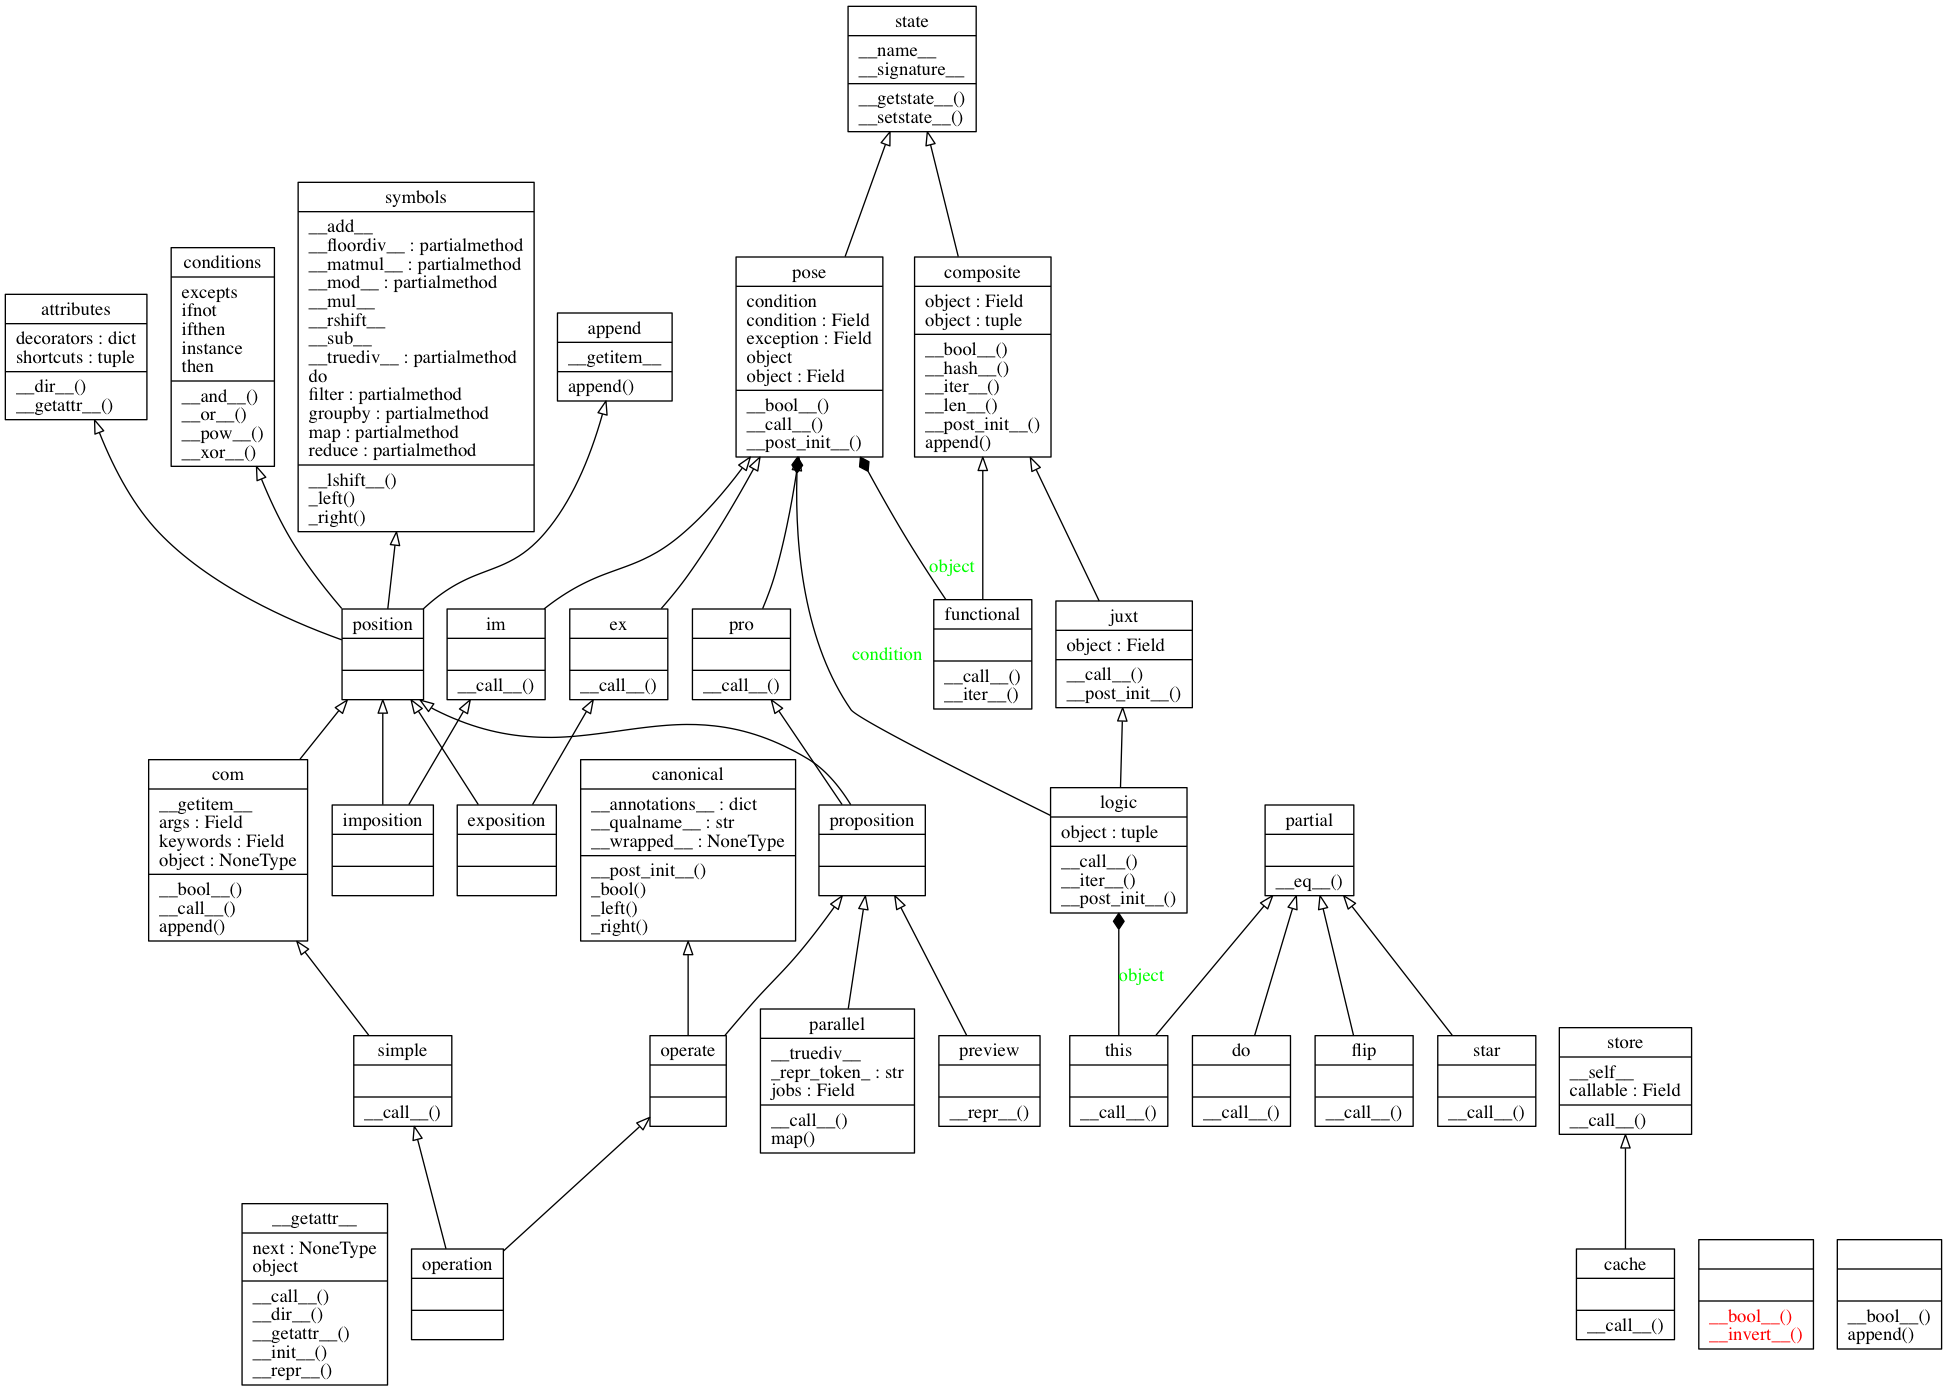

]0;IPython: tonyfast/compositeswrote poser.html


In [37]:
    if __name__ == '__main__':
        if 'runtime' in sys.argv[-1]:
            from IPython import get_ipython, display
            __import__('doctest').testmod()
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True poser.ipynb
            !source activate p6 && python -m pydoc -w poser
            !source activate p6 && pyreverse -o png -pposer -fALL poser
            display.display(display.Image('classes_poser.png'), display.IFrame('poser.html', height=600, width=800))
            
            !source activate p6 && ipython -m doctest poser.py
            !source activate p6 && python -m pydoc -w poser
        else:
            print('run from cli')